# Анализ данных пользователей GoFast
# Введение

Имеются данные о некоторых пользователях из нескольких городов, а также об их поездках пользователей сервиса аренды самокатов GoFast. Целью данной работы является анализ данных и проверка гипотез.

В основных данных есть информация о пользователях, их поездках и подписках. Есть дополнительная информация о количестве обращений пользователей в техподдержку сервиса до и после обновления технической инфраструктуры.

Начальные данные:
- Пользователи — users_go.csv
- Поездки — rides_go.csv
- Подписки — subscriptions_go.csv

Основные задачи:
- прочитать данные;
- провести предобработку;
- провести исследовательский анализ;
- объеденить данные;
- подсчитать выручку;
- провеить гипотезы;
- исследовать распределения (опционально);
- сделать выводы.

Подключим необходимы библиотеки и модули.

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
from matplotlib import pyplot as plt
from math import factorial
from math import sqrt
from scipy.stats import binom, norm

#### Шаг 1. Загрузка данных

##### Чтение исходных данных

Прочитаем исходные данные в датафреймы.

In [2]:
users_data = pd.read_csv('/datasets/users_go.csv')
rides_data = pd.read_csv('/datasets/rides_go.csv')
subscriptions_data = pd.read_csv('/datasets/subscriptions_go.csv')

##### Выведем первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.

In [3]:
display(users_data.head())
display(rides_data.head())
display(subscriptions_data.head())

users_data.info()
print()
rides_data.info()
print()
subscriptions_data.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 1565 entries, 0 to 1564

Data columns (total 5 columns):

 #   Column             Non-Null Count  Dtype 

---  ------             --------------  ----- 

 0   user_id            1565 non-null   int64 

 1   name               1565 non-null   object

 2   age                1565 non-null   int64 

 3   city               1565 non-null   object

 4   subscription_type  1565 non-null   object

dtypes: int64(2), object(3)

memory usage: 61.3+ KB



<class 'pandas.core.frame.DataFrame'>

RangeIndex: 18068 entries, 0 to 18067

Data columns (total 4 columns):

 #   Column    Non-Null Count  Dtype  

---  ------    --------------  -----  

 0   user_id   18068 non-null  int64  

 1   distance  18068 non-null  float64

 2   duration  18068 non-null  float64

 3   date      18068 non-null  object 

dtypes: float64(2), int64(1), object(1)

memory usage: 564.8+ KB



<class 'pandas.core.frame.DataFrame'>

RangeIndex: 2 entries, 0 to 1

Data column

Предварительно можно сказать, что данные хорошие, прочитались без проблем, в трех датафреймах не имеется ни одного пропуска. При предобработке данных рассмотрим данные более подробно.
Имеем следующие данные:
- users_data:
    - user_id - ID пользователя;
    - name - имя пользователя;
    - age - возраст пользователя;
    - city - город, в котором пользователь предположительно живет и пользуется сервисом;
    - subscription_type - тип подписки;
- rides_data:
    - user_id - ID пользователя;
    - distance - расстояние поездки (предположительно в метрах);
    - duration - время, которое заняла поездка (предположительно в минутах);
    - date - дата, когда была совершена поездка;
- subscriptions_data:
    - subscription_type - тип подписки;
    - minute_price - цена за 1 минуту поездки;
    - start_ride_price - стоимость старта (начала поездки);
    - subscription_fee - цена подписки.

#### Шаг 2. Предобработка данных

##### Приведем столбец date к типу даты Pandas.

In [4]:
rides_data['date'] = pd.to_datetime(rides_data['date'], format='%Y-%m-%d')

rides_data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 18068 entries, 0 to 18067

Data columns (total 4 columns):

 #   Column    Non-Null Count  Dtype         

---  ------    --------------  -----         

 0   user_id   18068 non-null  int64         

 1   distance  18068 non-null  float64       

 2   duration  18068 non-null  float64       

 3   date      18068 non-null  datetime64[ns]

dtypes: datetime64[ns](1), float64(2), int64(1)

memory usage: 564.8 KB


Видим в столбце date тип данных datetime64, значит всё работает.

##### Создадим новый столбец с номером месяца на основе столбца date.

Проверим, за какой период предоставлены данные.

In [5]:
print(rides_data['date'].min())
print(rides_data['date'].max())

2021-01-01 00:00:00

2021-12-30 00:00:00


Данные охватывают только 2021 год. Это значит можно спокойно выделить номер месяца, не опасаясь, что месяца из разных годов сольются.

In [6]:
rides_data['month'] = pd.DatetimeIndex(rides_data['date']).month
display(rides_data.head())

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Видим добавленный столбец month и по крайне мере в первых пяти строках значения в столбце соответствуют номеру месяца.

##### Проверим наличие пропущенных значений и дубликатов в датафреймах. Обработаем их, если такие значения присутствуют.

Из пункта 1.2 видим, что пропущенные значения во всех датафреймах отсутствуют.

Проверим явные дубликаты в users_data и rides_data, так как в subscriptions_data всего две строки и там всё и так видно и понятно.

In [7]:
print('Количество явных дубликатов в users_data:', users_data.duplicated().sum())
print('Количество явных дубликатов в rides_data:', rides_data.duplicated().sum())

Количество явных дубликатов в users_data: 31

Количество явных дубликатов в rides_data: 0


Удалим явные дубликаты в users_data и снова выведем подсчет дубликатов, чтобы убелиться, что всё получилось.

In [8]:
users_data = users_data.drop_duplicates()
print('Количество явных дубликатов в users_data:', users_data.duplicated().sum())
print('Количество пользователей:', users_data.shape[0])

Количество явных дубликатов в users_data: 0

Количество пользователей: 1534


Явные дубликаты удалены.

Неявные дубликаты если и есть, то скорее всего только в столце city в users_data, так как кроме стобца name все остальные столбцы не типа object. Проверим уникальные значения столбца city в users_data.

In [9]:
print(users_data['city'].unique())

['Тюмень' 'Омск' 'Москва' 'Ростов-на-Дону' 'Краснодар' 'Пятигорск'

 'Екатеринбург' 'Сочи']


Тут всё просто, неявные дубликаты отсутствуют.

#### Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках.

##### Частота встречаемости городов

Пятигорск         219

Екатеринбург      204

Ростов-на-Дону    198

Краснодар         193

Сочи              189

Омск              183

Тюмень            180

Москва            168

Name: city, dtype: int64


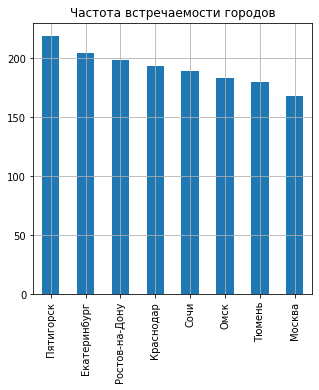

In [10]:
print(users_data['city'].value_counts())

temp_data = users_data['city'].value_counts().plot(kind='bar', 
                                                   grid=True, 
                                                   figsize=(5, 5), 
                                                   title=('Частота встречаемости городов'))

Самое большое количество пользователей в Пятигорске, а самое маленькое - в Москве.

##### Соотношение пользователей с подпиской и без подписки

free     835

ultra    699

Name: subscription_type, dtype: int64


Text(0, 0.5, 'Количество пользователей')

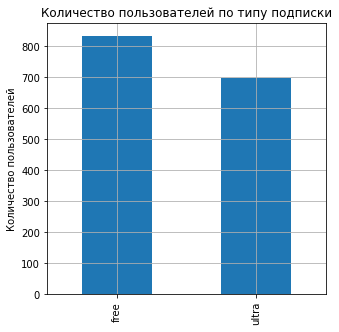

In [11]:
print(users_data['subscription_type'].value_counts())

temp_data = users_data['subscription_type'].value_counts().plot(kind='bar', 
                                                                grid=True, 
                                                                figsize=(5, 5), 
                                                                title=('Количество пользователей по типу подписки'))
temp_data.set_ylabel('Количество пользователей')

Построим еще на круговую диаграмму.

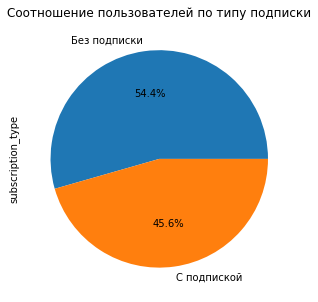

In [12]:
temp_data = users_data['subscription_type'].value_counts().plot(kind='pie', 
                                                                grid=True, 
                                                                figsize=(5, 5), 
                                                                title=('Соотношение пользователей по типу подписки'), 
                                                                labels = ('Без подписки', 'С подпиской'), 
                                                                autopct='%.1f%%')

Пользователей без подписки больше примерно на 19,5%.

##### Возраст пользователей

25    145

24    132

26    131

23    129

27    119

22    119

28    112

21     93

20     71

30     68

29     68

31     48

19     47

18     46

32     41

33     39

17     26

34     19

16     19

35     15

15     13

14      9

13      8

36      6

12      4

38      3

37      2

39      1

43      1

Name: age, dtype: int64


Text(0, 0.5, 'Количество пользователей')

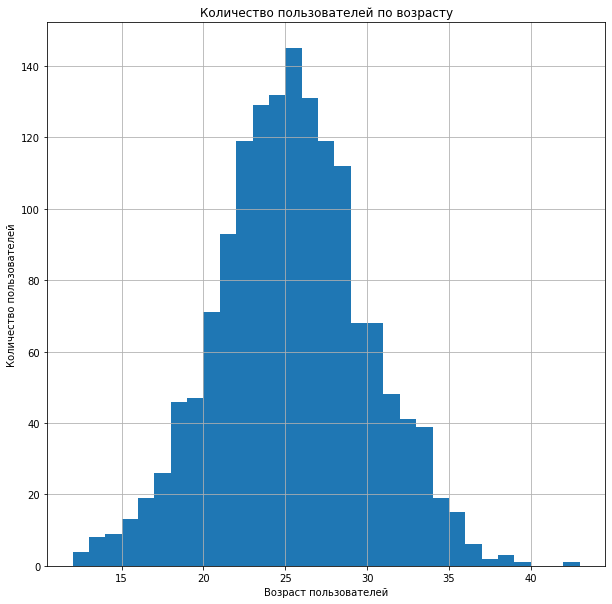

In [13]:
print(users_data['age'].value_counts())

temp_data_age = users_data['age'].plot(kind='hist', 
                                   grid=True, 
                                   bins=31, 
                                   figsize=(10, 10), 
                                   title=('Количество пользователей по возрасту'))
temp_data_age.set_xlabel("Возраст пользователей")
temp_data_age.set_ylabel("Количество пользователей")

Исследуем распределение.

In [14]:
users_data['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Считая от первого квантиля до третьего, можно сказать, что большинство клиентов в возрасте от 22 до 28 лет. Распределение выглядит нормальным.

##### Расстояние, которое пользователь преодолел за одну поездку

741.545359     1

4158.226381    1

3672.118870    1

4533.004089    1

2437.274120    1

              ..

2949.530545    1

3289.893471    1

3047.554085    1

2931.718067    1

4031.935032    1

Name: distance, Length: 18068, dtype: int64


Text(0, 0.5, 'Количество поездок')

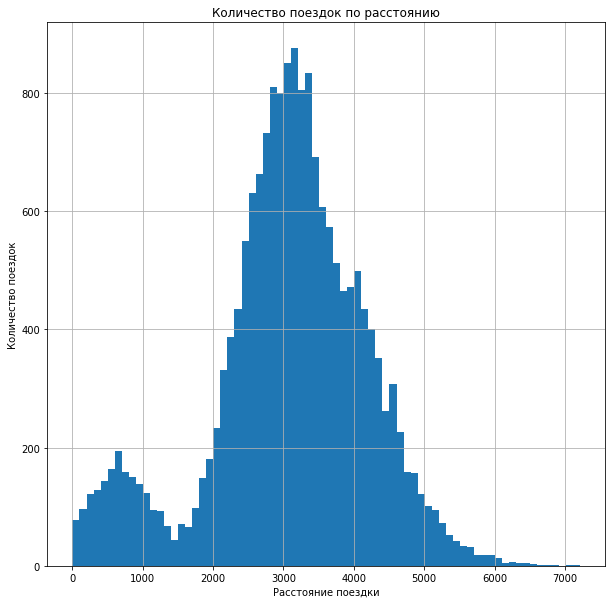

In [15]:
print(rides_data['distance'].value_counts())

temp_data_distance = rides_data['distance'].plot(kind='hist', 
                                                 grid=True, 
                                                 bins=72, 
                                                 figsize=(10, 10), 
                                                 title=('Количество поездок по расстоянию'))
temp_data_distance.set_xlabel("Расстояние поездки")
temp_data_distance.set_ylabel("Количество поездок")

In [16]:
rides_data['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Судя по графику, в основном пользователи ездят на близкие дистанции в районе около 700 метров и на чуть дальние расстояния от 1.5 до 5.5 км. 
Исследовав распределение, можно сказать, что большинство поездок на расстояние примерно от 2543 до 3776 метров.
Если не брать в расчет пик в начале до 1500 метров, распределение можно считать нормальным.

##### Продолжительность поездок

0.500000     95

22.184080     1

25.866000     1

22.837062     1

19.173800     1

             ..

18.843765     1

17.644888     1

22.477965     1

19.745218     1

16.537044     1

Name: duration, Length: 17974, dtype: int64


Text(0, 0.5, 'Количество поездок')

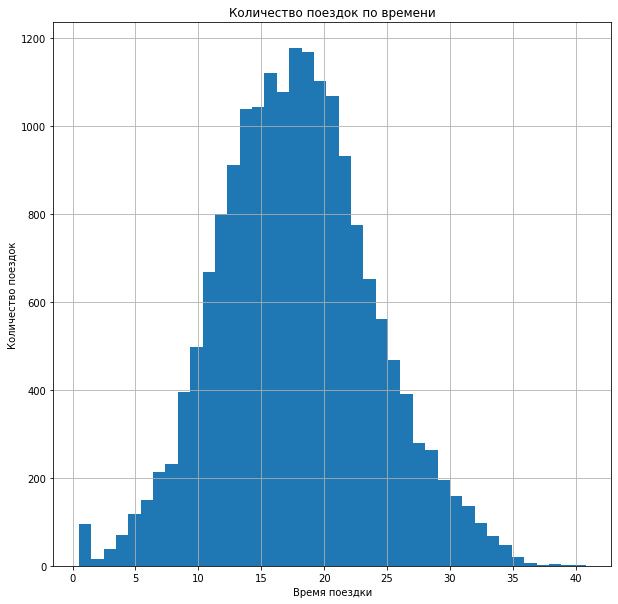

In [17]:
print(rides_data['duration'].value_counts())

temp_data_duration = rides_data['duration'].plot(kind='hist', 
                                                 grid=True, 
                                                 bins=41, 
                                                 figsize=(10, 10), 
                                                 title=('Количество поездок по времени'))
temp_data_duration.set_xlabel("Время поездки")
temp_data_duration.set_ylabel("Количество поездок")

In [18]:
rides_data['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Видим небольшой пик в районе 1 минуты. Скорее всего это заезды клиентов, которые они делали, чтобы опробовать сервис.  

Исследовав распределение, можно сказать, что в основоном время поездки клиентов составляет от 13 до 22 минут.  
В остальном распределение выглядит нормальными.

#### Шаг 4. Объединение данных

##### Объединим данные о пользователях, поездках и подписках в один датафрейм

Для начала объеденим датафреймы users_data и rides_data. Логично, что объединять нужно опираясь на user_id, и что нужно users_data "заливать" в rides_data, так получим наиболее полный датафрейм. Онднако, возможно такое, что пользователь зарегистрировался, но поездок не совершал. Проверим есть ли такие.

In [19]:
print('Количество пользователей, совершивших поездку:', rides_data['user_id'].nunique())
print('Количество зарегестрированных пользователей:', users_data['user_id'].nunique())

Количество пользователей, совершивших поездку: 1534

Количество зарегестрированных пользователей: 1534


Будем надеяться, что совпадает не только количество пользователей, но и сами id. То есть можно смело объединять, данные не должны потеряться и не должно появиться пропусков.

In [20]:
data = rides_data.merge(users_data, on='user_id', how='left')
display(data)

,user_id,distance,duration,date,month,name,age,city,subscription_type
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra
...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free


Как было 18068 строк, так и осталось. Видим, что к столбцам из rides_data справа добавились столбцы из users_data.

Теперь "зальем" в получившийся датафрейм subscriptions_data. Объединять будем по subscription_type.

In [21]:
data = data.merge(subscriptions_data, on='subscription_type', how='left')
display(data)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


18068 строк осталось неизменно. Видим, что к столбцам из data справа добавились столбцы из subscriptions_data.

Получили датафрейм data, который объединил в себе 3 исходных датафрейма.

##### Создадим ещё два датафрейма из датафрейма, созданного на предыдущем этапе

На всякий случай, чтобы потом проверить новые датафреймы, посчитаем количество поездок без подписки и с подпиской.

In [22]:
print('Поездки без подписки:', data[data['subscription_type']=='free']['subscription_type'].count())
print('Поездки с подписой:', data[data['subscription_type']=='ultra']['subscription_type'].count())

Поездки без подписки: 11568

Поездки с подписой: 6500


Разделим общий датафрейм по типу подписки. Выведем количество строк в новых датафреймах, чтобы убедиться, что всё разделилось корректно.

In [23]:
data_free = data[data['subscription_type']=='free']
data_ultra = data[data['subscription_type']=='ultra']

print('Количество строк в data_free', data_free.shape[0])
print('Количество строк в data_ultra', data_ultra.shape[0])

Количество строк в data_free 11568

Количество строк в data_ultra 6500


Количество строк в каждом датафрейме совпадает с расчитанными ранее строками по типу подписки.

##### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

Расстояние поездок.

Text(0, 0.5, 'Количество поездок')

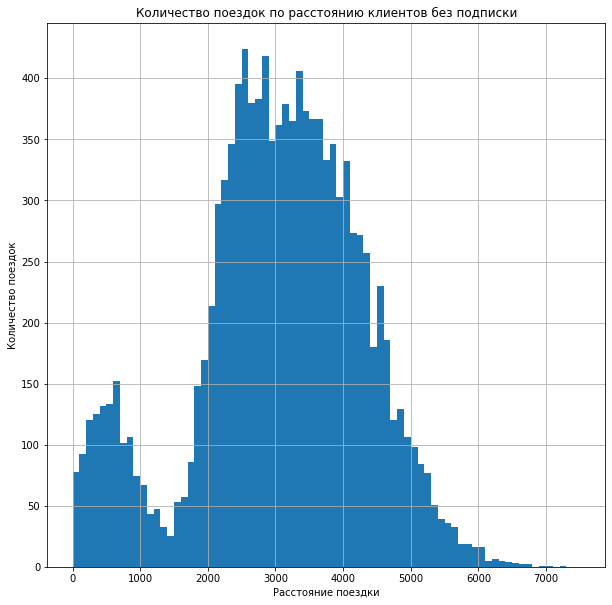

In [24]:
temp_data_distance_free = data_free['distance'].plot(kind='hist', 
                                                 grid=True, 
                                                 bins=75,
                                                 range=(0, 7500), 
                                                 figsize=(10, 10), 
                                                 title=('Количество поездок по расстоянию клиентов без подписки'))
temp_data_distance_free.set_xlabel("Расстояние поездки")
temp_data_distance_free.set_ylabel("Количество поездок")

Text(0, 0.5, 'Количество поездок')

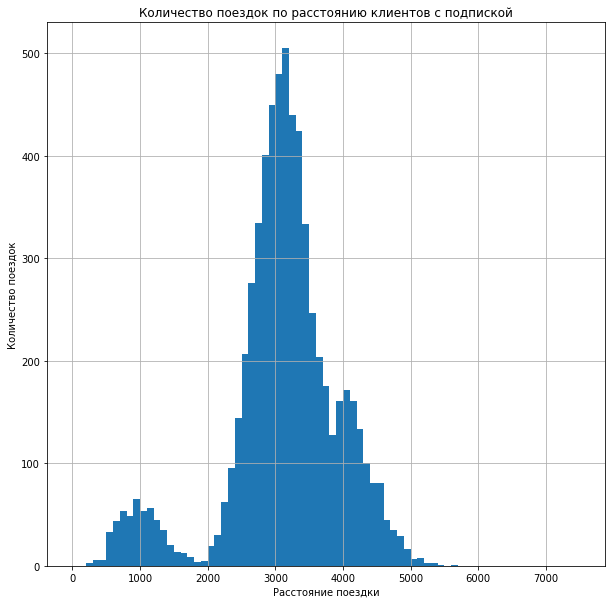

In [25]:
temp_data_distance_ultra = data_ultra['distance'].plot(kind='hist', 
                                                 grid=True, 
                                                 bins=75,
                                                 range=(0, 7500), 
                                                 figsize=(10, 10), 
                                                 title=('Количество поездок по расстоянию клиентов с подпиской'))
temp_data_distance_ultra.set_xlabel("Расстояние поездки")
temp_data_distance_ultra.set_ylabel("Количество поездок")

На первом графике изображена гистограмма растояний, совершенных пользователями без подписок, а а втором - с подписками. Видим на обоих графиках пик в начале, затем спад, а далее практически нормальное распределение.

Время поездок.

Text(0, 0.5, 'Количество поездок')

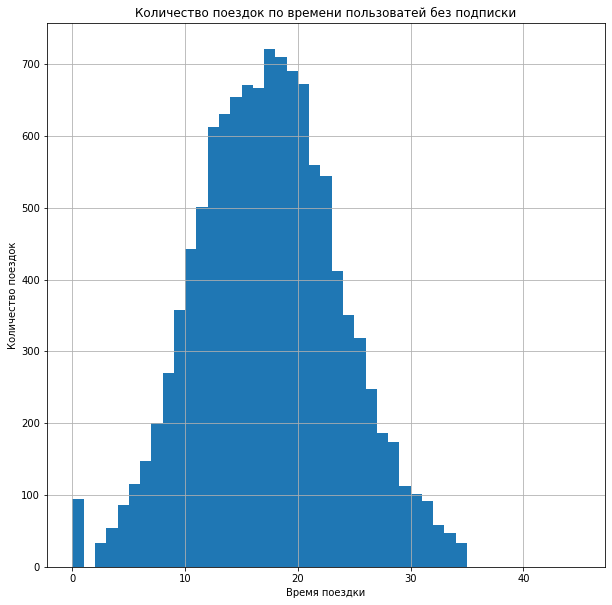

In [26]:
temp_data_duration_free = data_free['duration'].plot(kind='hist', 
                                                 grid=True, 
                                                 bins=45,
                                                 range=(0, 45), 
                                                 figsize=(10, 10), 
                                                 title=('Количество поездок по времени пользоватей без подписки'))
temp_data_duration_free.set_xlabel("Время поездки")
temp_data_duration_free.set_ylabel("Количество поездок")

Text(0, 0.5, 'Количество поездок')

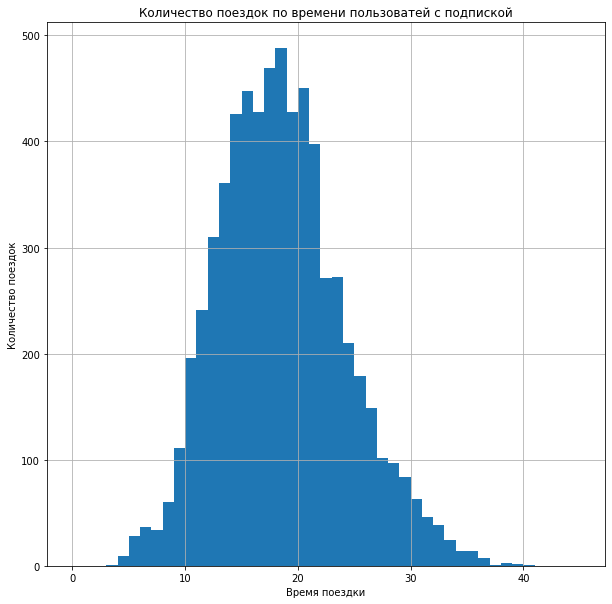

In [27]:
temp_data_duration_ultra = data_ultra['duration'].plot(kind='hist', 
                                                 grid=True, 
                                                 bins=45,
                                                 range=(0, 45), 
                                                 figsize=(10, 10), 
                                                 title=('Количество поездок по времени пользоватей с подпиской'))
temp_data_duration_ultra.set_xlabel("Время поездки")
temp_data_duration_ultra.set_ylabel("Количество поездок")

На первом графике изображена гистограмма времени поездок, совершенных ползователями без подписок, а а втором - с подписками. На втором графиках отсутствует пик в районе 1 минуты, что косвенно подтверждает предположение, что это пробные заезды пользователей. В остальном, графики очень схожи и распределение можно назвать нормальным.

#### Шаг 5. Подсчёт выручки

##### Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

Для этого создадим новый датафрейм из объединенного.

In [28]:
#Создадим сводную таблицу по distance и duration, группируя по user_id и month,
#применяя расчет суммы и количества, сбросим индекс
data_agrigated = data.pivot_table(index=('user_id', 'month'), 
                                  values=('distance', 'duration'), 
                                  aggfunc=('sum', 'count')).reset_index()
#display(data_agrigated)
#print(data_agrigated.columns)

#Переименуем столбцы, отметив задублировавшийся столбец как for_drop
data_agrigated.columns = ['user_id', 'month', 'total_rides', 'sum_ distance', 'for_drop', 'sum_duration']

#Удалим задублировавшийся столбец for_drop
data_agrigated = data_agrigated.drop('for_drop', axis=1)

display(data_agrigated)
print('Количество срок:', data_agrigated.shape[0])

,user_id,month,total_rides,sum_ distance,sum_duration
0,1,1,2,7027.511294,41.416640
1,1,4,1,754.159807,6.232113
2,1,8,2,6723.470560,44.776802
3,1,10,2,5809.911100,31.578017
4,1,11,3,7003.499363,53.397424
...,...,...,...,...,...
11326,1534,6,2,3409.468534,24.812678
11327,1534,8,2,7622.453034,47.205960
11328,1534,9,1,4928.173852,22.560373
11329,1534,11,4,13350.015305,76.342174


Количество срок: 11331


Создали новый датафрейм, где:
- month - месяц, в котором совершались поездки;
- user_id - ID пользователя;
- total_rides - суммарное количество поездок пользователя;
- sum_distance - суммарное пройденное расстояние;
- sum_duration - суммарное время поездок.

##### Добавим столбец с помесячной выручкой, которую принёс каждый пользователь

Создадим временный датафрейм, в который, так же группируя по user_id и month, возьмем первые значения для столбцов start_ride_price, minute_price, subscription_fee.

In [29]:
temp_data = data.pivot_table(
    index=('user_id', 'month'), 
    values=('start_ride_price', 'minute_price', 'subscription_fee'), 
    aggfunc='first').reset_index()
display(temp_data)

,user_id,month,minute_price,start_ride_price,subscription_fee
0,1,1,6,0,199
1,1,4,6,0,199
2,1,8,6,0,199
3,1,10,6,0,199
4,1,11,6,0,199
...,...,...,...,...,...
11326,1534,6,8,50,0
11327,1534,8,8,50,0
11328,1534,9,8,50,0
11329,1534,11,8,50,0


Количество строк совпадает с data_agrigated, значит теперь можно перемножить нужные столбцы и получить искомое значение выручки.

Месячная выручка будет равна "стоимость старта * количество поездок + цена минуты * количество минут + цена подписки".  
По заданию время поездок округляется до целых чисел.

In [30]:
data_agrigated['earning'] = temp_data['start_ride_price'] * data_agrigated['total_rides'] + \
temp_data['minute_price'] * data_agrigated['sum_duration'].round(0) + temp_data['subscription_fee']

display(data_agrigated)

,user_id,month,total_rides,sum_ distance,sum_duration,earning
0,1,1,2,7027.511294,41.416640,445.0
1,1,4,1,754.159807,6.232113,235.0
2,1,8,2,6723.470560,44.776802,469.0
3,1,10,2,5809.911100,31.578017,391.0
4,1,11,3,7003.499363,53.397424,517.0
...,...,...,...,...,...,...
11326,1534,6,2,3409.468534,24.812678,300.0
11327,1534,8,2,7622.453034,47.205960,476.0
11328,1534,9,1,4928.173852,22.560373,234.0
11329,1534,11,4,13350.015305,76.342174,808.0


#### Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки и выгоднее ли для компании?

Нулевая гипотеза - среднее время одной поездки пользователей с подпиской и без подписки равны.  
Альтернативная гипотеза - пользователи с подпиской тратят больше времени на поездки.

Зададим уровень статистической значимости 0,05 и посчитаем p-value. В данном случае, p-value будет для двусторонней гипотезы, а для односторонней нужно взять половину. Если половина от p-value окажется меньше уровня статистической значимости, отвергнем нулевую гипотезу.

In [31]:
# уровень статистической значимости
alpha = 0.05

results = st.ttest_ind(data_ultra['duration'], data_free['duration'])

print('Половина p-значения:', results.pvalue / 2)

if results.pvalue / 2 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Половина p-значения: 1.2804098316645618e-34

Отвергаем нулевую гипотезу


То есть пользователи с подпиской вероятнее всего в среднем тратят больше времени на поездки, чем пользователи без подписки.

In [32]:
# уровень статистической значимости
alpha = 0.05

results = st.ttest_ind(data_agrigated[data_agrigated['user_id'].isin(data_ultra['user_id'])]['earning'], 
                       data_agrigated[data_agrigated['user_id'].isin(data_free['user_id'])]['earning'])

print('Половина p-значения:', results.pvalue / 2)

if results.pvalue / 2 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Половина p-значения: 2.3546897309064956e-37

Отвергаем нулевую гипотезу


То есть пользователи с подпиской вероятнее всего выгоднее для компании.

##### Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров?

Нулевая гипотеза - пользователи с подпиской проезжают за одну поездку 3130 метров.  
Альтернативная гипотеза - пользователи с подпиской проезжают за одну поездку меньше 3130 метров.

In [33]:
# расстояние, которое должен проезжать пользователь с подпиской
interested_value = 3130

# уровень статистической значимости
alpha = 0.05

results = st.ttest_1samp(data_ultra['distance'], interested_value, alternative='less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.08046311521502146

Не отвергаем нулевую гипотезу


То есть можно сказать, маловероятно, что пользователи с подпиской проезжают за одну поездку меньше 3130 метров.

##### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Нулевая гипотеза - выручка по месяцам от клиентов с подпиской равна выручке по месяцам от клиентов без подписки.  
Альтернативная гипотеза - выручка по месяцам от клиентов с подпиской больше выручки по месяцам от клиентов без подписки.

In [34]:
# уровень статистической значимости
alpha = 0.05

results = st.ttest_ind(data_agrigated[data_agrigated['user_id'].isin(data_ultra['user_id'])].groupby('month')['earning'].sum(), 
                       data_agrigated[data_agrigated['user_id'].isin(data_free['user_id'])].groupby('month')['earning'].sum())

print('Половина p-значения:', results.pvalue / 2)

if results.pvalue / 2 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Половина p-значения: 4.241131815828218e-13

Отвергаем нулевую гипотезу


То есть с большой вероятностью помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

##### Какой тест понадобился бы для проверки гипотезы?

**Имеется предположительное задание:**  
Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. 

**Вопрос звучит следующим образом:**  
Какой тест понадобился бы для проверки гипотезы?

**Ответ:**
Так как в распоряжении были бы датафреймы, которые между собой взаимосвязаны, то для теста необходимо было бы использовать гипотезу о равенстве средних для зависимых (парных) выборок. А метод для сравнения использовался бы scipy.stats.ttest_rel(), с последующим сравнением p-значения с уровнем статической значимости.

#### Шаг 7. Распределения

##### Задача от отдела маркетинга. Продление подписки

Перефразировав, задание можно сформулировать так:

Какое количество нужно разослать промокодов, чтобы при 10% успехе переподписалось как минимум 100 существующих клиентов?

Пусть n - количество клиентов (его мы будем искать), которым нужно разослать промокод, а p - вероятность того, что клиент переподпишется, то есть 10%.

<BarContainer object of 1001 artists>

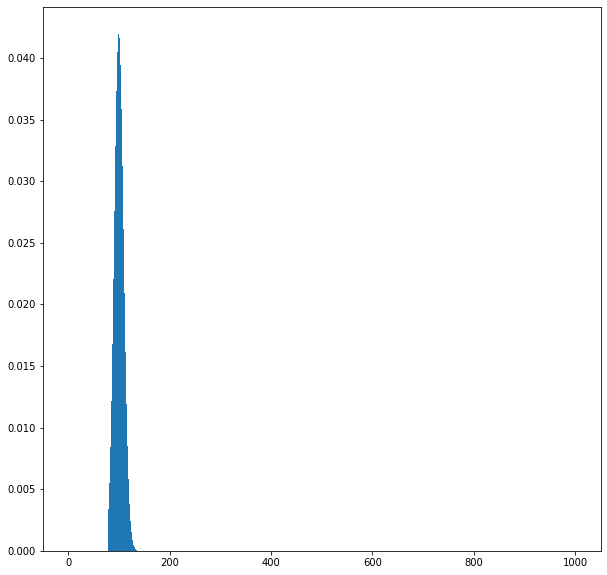

In [35]:
n = 1000
p = 0.1

distr = []
for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k) 
    distr.append(prob)
    
plt.figure(figsize=(10, 10))
plt.bar(range(0, n + 1), distr)

Построен график биномиального распределения всего для 1000 значений, а его уже с трудом можно рассматривать, причем видно, что значений n нужно намного больше, так как вероятность получить значение менее 100 переподписок всего примерно 50%. Благо, график  коррелирует с нормальным распределением, так что для нахождения n будем использовать нормальную аппроксимацию. Значение n будем подбирать.

In [36]:
# задаём параметры биномиального распределения
n = 1300
p = 0.1

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# желаемое значение подисок
value = 100

# считаем вероятность получить значение value или больше
result = distr.cdf(value)
print('Вероятность получить значение менее 100:', 1-result)

Вероятность получить значение менее 100: 0.997227166342378


**Вывод:**
Если разослать промокод 1300 клиентам, то получим 100 переподписавшихся клиентов с вероятностью 99.7%

##### Задача от отдела маркетинга. Push-уведомления

Перефразировав, задание можно сформулировать так:

Оценить вероятность, что, если разослать 1 млн уведомлений при вероятности открытия уведомление 40%, пользователи откроют не более 399.5 тыс уведомлений.

С таким большим количеством разосланных уведомлений n даже график биномиального распределения построить проблематично. Благо, мы знаем, что при большом числе событий n биномиальное распределение приближается к нормальному. Поэтому будем использовать нормальную аппроксимацию биномиального распределения. Учитывая, что количество открывших пользователей считается в тысячах, будем считать 1 млн. как 1000 тыс.

Проверим возможность использования нормальной аппроксимации биномиального распределения.

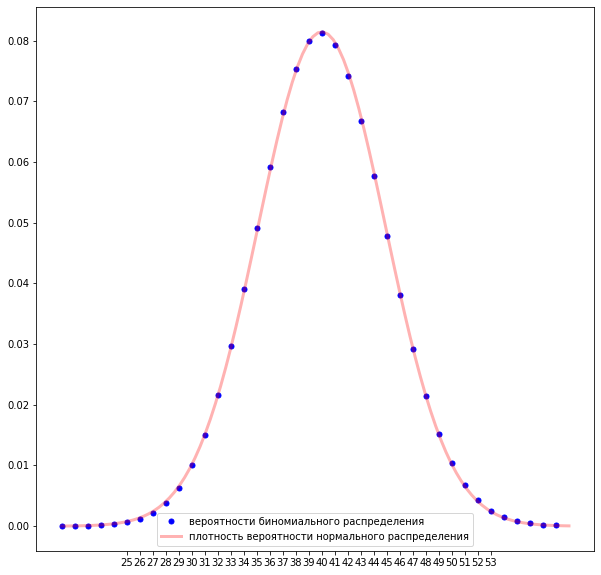

Условие выполняется


In [37]:
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
# задаём параметры биномиального распределения
n = 100
p = 0.40

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
plt.figure(figsize=(10, 10))
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5,
       label='вероятности биномиального распределения')

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='плотность вероятности нормального распределения')
 
# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))
ax.set_xticks(x_ticks)

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

Видим как распределяются значения вероятности биномиального распределения и плотность вероятности нормального распределения. Возможность применения нормальной аппроксимации на лицо.

Расчитаем вероятность того, что просмотров push-уведомлений будет менее 399.5 тыс.

In [38]:
# задаём параметры биномиального распределения
n = 1000
p = 0.4

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# желаемое значение
value = 399.5

# считаем вероятность получить значение value или больше
result = distr.cdf(value)
print('Вероятность получить значение менее 399.5 тыс.:', (1-result))

Вероятность получить значение менее 399.5 тыс.: 0.5128735717002281


То есть количество просмотренных push-уведомлений будет менее 399.5 тыс с вероятностью около 51%.

**Заключение**

Получив и предварительно обработав данные можно сказать, что качество данных на хорошем уровне. Нашлось только несколько явных дубликтов.

Основные выводы:
- Самое большое количество пользователей в Пятигорске, а самое маленькое - в Москве.
- Пользователей без подписки больше примерно на 19,5%.
- Большинство клиентов в возрасте от 22 до 28 лет.
- В основном пользователи ездат на близкие дистанции в районе около 700 метров и на чуть дальние расстояния от 1.5 до 5.5 км. Исследовав распределение, можно сказать, что большинство поездок на расстояние примерно от 2543 до 3776 метров.
- В основоном время поездки клиентов составляет от 13 до 22 минут.
- Пользователи с подпиской вероятнее всего в среднем тратят больше времени на поездки, чем пользователи без подписки, и выгоднее компании, так как в среднем вероятнее всего приносят больше выручки.
- Пользователи с подпиской проезжают за одну поездку меньше 3130 метров с очень маленькой вероятностью.
- С большой вероятностью помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
- Если разослать 1300 промокодов, чтобы при 10% успехе переподписалось как минимум 100 существующих клиентов c вероятностью 99.7%.
- Если разослать 1 млн. push-уведомлений, то с успехом в 40% их просмотрит 399.5 тыс клиентов с вероятностью 51%.